In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder \
    .appName("ExpenseAnalysis") \
    .getOrCreate()

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload combined_expenses.csv from Week 2

Saving combined_expenses.csv to combined_expenses.csv


In [5]:
from pyspark.sql.functions import col, sum, count, avg, date_format
from pyspark.sql.window import Window
import pandas as pd
import io

# Load data (replace with your upload method)
# Assuming the uploaded file is named 'combined_expenses.csv'
df = pd.read_csv(io.BytesIO(uploaded['combined_expenses.csv']))
spark_df = spark.createDataFrame(df)

# Convert types
spark_df = spark_df.withColumn("amount", col("amount").cast("float")) \
                   .withColumn("date", col("date").cast("timestamp"))

# Anomaly detection
monthly_spending = spark_df.groupBy(
    date_format("date", "yyyy-MM").alias("month"),
    "user"
).agg(
    sum("amount").alias("total_spent"),
    count("*").alias("transaction_count")
)

# Flag spending > 2x user's average
window = Window.partitionBy("user").orderBy("month")
anomalies = monthly_spending.withColumn(
    "avg_spending", avg("total_spent").over(window)
).withColumn(
    "is_anomaly", col("total_spent") > (col("avg_spending") * 2)
).filter(col("is_anomaly"))

# Show results
anomalies.show()

# Save to Colab storage
anomalies.toPandas().to_csv("anomalies.csv")
files.download("anomalies.csv")  # Download to your computer

+-------+------------+-----------+-----------------+-----------------+----------+
|  month|        user|total_spent|transaction_count|     avg_spending|is_anomaly|
+-------+------------+-----------+-----------------+-----------------+----------+
|2023-12|Emma Johnson|     1250.0|                1|541.7333323160807|      true|
+-------+------------+-----------+-----------------+-----------------+----------+



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

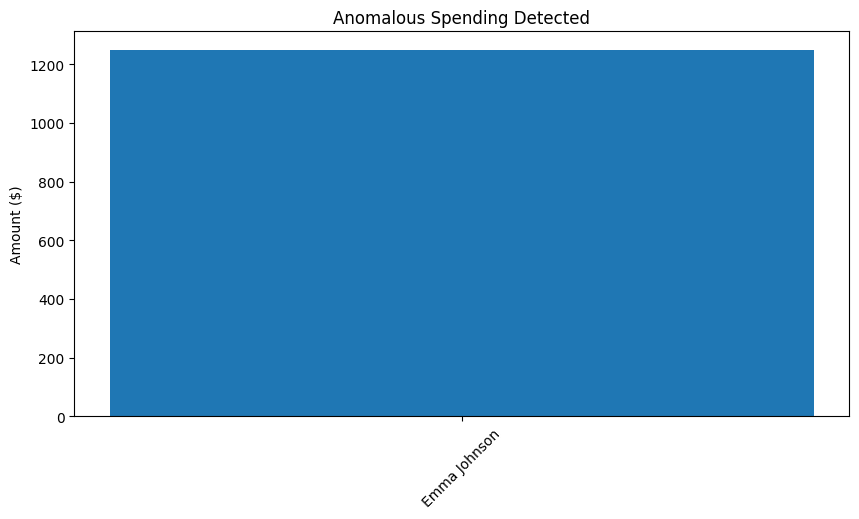

In [6]:
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
anomalies_pd = anomalies.toPandas()

if not anomalies_pd.empty:
    plt.figure(figsize=(10, 5))
    plt.bar(anomalies_pd["user"], anomalies_pd["total_spent"])
    plt.title("Anomalous Spending Detected")
    plt.ylabel("Amount ($)")
    plt.xticks(rotation=45)
    plt.show()